# 纽约市出租车行程预测
## 一、数据处理
### 1.1 数据来源
除了给定的出租车数据，在网上还找到了一下数据集：
- [出租车行程数据集](https://www.kaggle.com/datasets/yasserh/nyc-taxi-trip-duration)
- [2016年纽约市天气数据](https://www.kaggle.com/datasets/cabaki/knycmetars2016?resource=download)
- [2016年纽约市节假日数据](https://www.kaggle.com/datasets/pceccon/nyc2016holidays)
- [2016年纽约市1KM分辨率人口](https://hub.worldpop.org/geodata/summary?id=80022)



In [2]:
# taxi_travel_time_prediction.ipynb
import pandas as pd
import numpy as np
from datetime import datetime, date

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import xgboost as xgb
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans, KMeans
import optuna
import optuna.integration.lightgbm as oplgb

import warnings
warnings.filterwarnings('ignore')

### 1.2读取数据集

In [3]:
# 1.读取训练和预测集
# 参数parse_dates可以解析日期格式
train_df = pd.read_csv('../实习二数据/train.csv', parse_dates=['pickup_datetime', 'dropoff_datetime'])
test_df = pd.read_csv('../实习二数据/test.csv', parse_dates=['pickup_datetime'])
dfs = [train_df, test_df]

# 显示数据集的前1行
print(dfs[0].shape, dfs[1].shape)
print("训练集和测试集的前1行数据：")
print(dfs[0].head(1))
print(dfs[1].head(1))

# 2.读取节假日数据
holiday = pd.read_csv('../实习二数据/NYC_2016Holidays.csv', sep=';', parse_dates=['Date'])
# 将假期数据转换为与数据集一致的datetime格式
holiday['Date'] = holiday['Date'].apply(lambda x: x + ' 2016')
holidays = [datetime.strptime(holiday.loc[i, 'Date'], '%B %d %Y').date() for i in range(len(holiday))]
holidays[:3]

# 3.读取天气数据
# 读取天气数据
weather = pd.read_csv('../实习二数据/KNYC_Metars.csv', parse_dates=['Time'])
print("天气数据集前一行：")
print(weather.head(1))

(1458644, 11) (625134, 9)
训练集和测试集的前1行数据：
          id  vendor_id     pickup_datetime    dropoff_datetime  \
0  id2875421          2 2016-03-14 17:24:55 2016-03-14 17:32:30   

   passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                1        -73.982155        40.767937          -73.96463   

   dropoff_latitude store_and_fwd_flag  trip_duration  
0         40.765602                  N            455  
          id  vendor_id     pickup_datetime  passenger_count  \
0  id3004672          1 2016-06-30 23:59:58                1   

   pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
0        -73.988129        40.732029         -73.990173          40.75668   

  store_and_fwd_flag  
0                  N  
天气数据集前一行：
                 Time  Temp.  Windchill  Heat Index  Humidity  Pressure  \
0 2015-12-31 02:00:00    7.8        7.1         NaN      0.89    1017.0   

   Dew Point  Visibility Wind Dir  Wind Speed  Gust Speed  Precip Ev

## 二、数据清洗

缺失值检查：
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   id                  1458644 non-null  object        
 1   vendor_id           1458644 non-null  int64         
 2   pickup_datetime     1458644 non-null  datetime64[ns]
 3   dropoff_datetime    1458644 non-null  datetime64[ns]
 4   passenger_count     1458644 non-null  int64         
 5   pickup_longitude    1458644 non-null  float64       
 6   pickup_latitude     1458644 non-null  float64       
 7   dropoff_longitude   1458644 non-null  float64       
 8   dropoff_latitude    1458644 non-null  float64       
 9   store_and_fwd_flag  1458644 non-null  object        
 10  trip_duration       1458644 non-null  int64         
dtypes: datetime64[ns](2), float64(4), int64(3), object(2)
memory usage: 122.4+ MB
描述性统计：
       vendor_id                pick

<Axes: ylabel='trip_duration'>

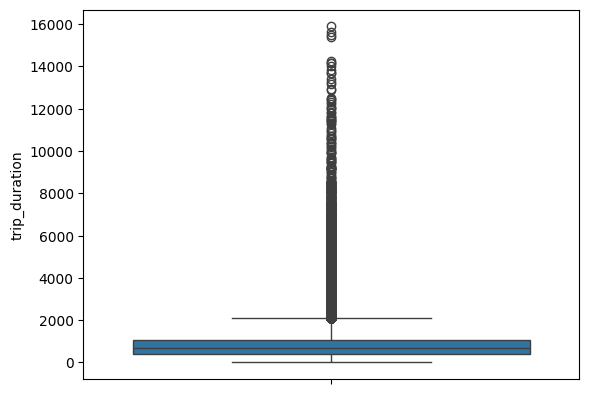

In [4]:
# 1.检查缺失值
print("缺失值检查：")
dfs[0].info() # 根据输出未发现缺失值

# 2.异常值
# 2.1 描述型统计
pd.set_option('display.float_format', lambda x: '%.2f' % x)
print("描述性统计：")
print(dfs[0].describe())# 查看描述性统计，发现有不合理的值

# 2.2 passenger_count异常值处理
print("训练集和测试集的passenger_count各种取值数量：")
print(dfs[0].passenger_count.value_counts())
print(dfs[1].passenger_count.value_counts())
for i in range(len(dfs)):
    # TODO: 不如直接删除，以及更优秀的异常值发现方法
    dfs[i]['passenger_count'].replace({
            0:1,7:6,8:6,9:6},inplace=True) # 采用最邻近替换掉异常值0，7，8，9

# 2.3 trip_duration异常值处理
# 查看trip_duration的均值、标准差
time_mean = np.mean(dfs[0].trip_duration)
time_std = np.std(dfs[0].trip_duration)
print(time_mean, time_std)
# 删除异常值
dfs[0] = dfs[0][(dfs[0]['trip_duration']<=(time_mean + 3 * time_std)) & (dfs[0]['trip_duration']>=(time_mean - 3 * time_std))]
# 用正态删除了最大的异常值，但没有删除最小的异常值
# TODO: 最小异常值这样处理还是太简单了
dfs[0] = dfs[0][dfs[0]['trip_duration']!=1]
sns.boxplot(dfs[0]['trip_duration'])# 查看去除异常值后的trip_duration分布

## 三、特征工程与EDA
### 3.1 时间特征

- 由上面的分析可以发现，trip_duration的标准差为5237.43，说明行程时间数据差异大，为减小数据差异带来的干扰，将数据log化：log_trip_duration
- 提取时间特征
- 是否是工作日、节假日
- 将时段分为早晚高峰、白天、夜晚

log_trip_duration分布：


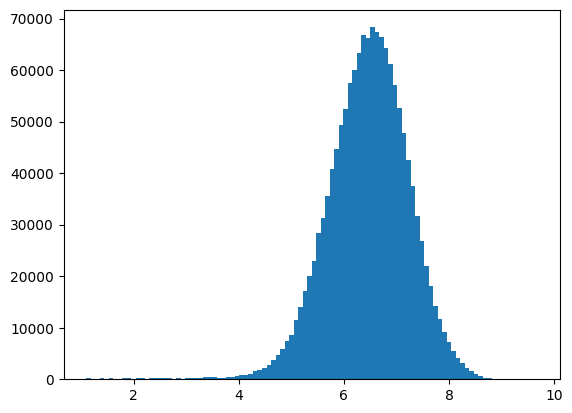

In [5]:
# 3.1 log_trip_duration取对数
dfs[0]['log_trip_duration'] = np.log(dfs[0]['trip_duration'].values + 1)
print("log_trip_duration分布：")
plt.hist(dfs[0]['log_trip_duration'].values, bins=100)
plt.show()

# 3.2 提取时间特征
# 提取年、月、日、小时、分钟、星期、日期
for i, d in enumerate(dfs):
    dfs[i]['year'] = d.pickup_datetime.dt.year
    dfs[i]['month'] = d.pickup_datetime.dt.month
    dfs[i]['day'] = d.pickup_datetime.dt.day
    dfs[i]['hour'] = d.pickup_datetime.dt.hour
    dfs[i]['minute'] = d.pickup_datetime.dt.minute
    dfs[i]['dayofweek'] = d.pickup_datetime.dt.dayofweek
    dfs[i]['date'] = d.pickup_datetime.dt.date
    dfs[i]['time'] = d.hour + d.minute/60

# 判断是否工作日、是否节假日
for i, d in enumerate(dfs):
    dfs[i]['is_weekend'] = d['dayofweek'].apply(lambda x: 1 if x==5 or x==6 else 0)
    dfs[i]['is_rest'] = d['date'].apply(lambda x: 1 if x in holidays else 0)

# 24小时切分为不同时段：早高峰、晚高峰、白天、夜晚
def get_time_interval(series):
    hour = series['hour']
    is_rest = series['is_rest']
    
    if is_rest==1:
        if hour>=7 and hour<=21:
            time_interval='day'
        elif hour>21 or hour<7:
            time_interval='night'
    elif is_rest==0:
        if hour>=7 and hour<=9: 
            time_interval='morning_peak'
        elif hour>=17 and hour<=21:
            time_interval='evening_peak'
        elif hour>9 and hour<17:
            time_interval='day'
        elif hour>21 or hour<7:
            time_interval='night'
    return time_interval

for i, d in enumerate(dfs):
    dfs[i]['time_interval'] = d.apply(get_time_interval, axis=1)



### 3.2 天气特征  

In [6]:
# 3.3 天气特征
print("各类天气数量：")
print(weather.Events.value_counts())
# 将天气加上时间标签：
# 提取天气特征的年月日等时间特征，并筛选年份天气等特征。
weather['year'] = weather.Time.dt.year
weather['month'] = weather.Time.dt.month
weather['day'] = weather.Time.dt.day
weather['hour'] = weather.Time.dt.hour
weather['events_weather'] = weather['Events'].apply(lambda x: 0 if x=='None' else 1)
weather = weather[weather['year']==2016][['Temp.', 'Visibility', 'events_weather', 'month', 'day','hour', 'Precip']]
# 与上车时间合并
for i, d in enumerate(dfs):
    dfs[i] = pd.merge(d, weather, on=['month', 'day', 'hour'], how='left')

各类天气数量：
Events
Rain              377
Snow               51
Fog\n\t,\nSnow     23
Fog                 2
Fog\n\t,\nRain      2
Name: count, dtype: int64


### 3.3 距离特征

In [7]:
# 计算经纬度之间的距离
def haversine(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return round(c * 6371, 3) # 地球平均半径，6371km

# 单位：km
for i, d in enumerate(dfs):
    dfs[i]['haversine'] = d.apply(lambda x: haversine(x['pickup_longitude'], x['pickup_latitude'], x['dropoff_longitude'], x['dropoff_latitude']), axis=1)

### 3.4 区域特征
- 对经纬度用kmeans聚类，创建区域特征分为15个类别：(感觉不太好)
数据集太大，所以用MiniBatchKMeans代替，能够对小规模子集进行计算，减少计算时间。
- 对经纬度用PCA，创建新特征

In [8]:

# 先将所有需要转换的数据汇总，一起放入fit
coords = np.vstack((dfs[0][['pickup_longitude', 'pickup_latitude']].values,
                    dfs[0][['dropoff_longitude', 'dropoff_latitude']].values,
                    dfs[1][['pickup_longitude', 'pickup_latitude']].values,
                    dfs[1][['dropoff_longitude', 'dropoff_latitude']].values))
# 随机采样
sample_ids = np.random.permutation(len(coords))[:1000000]
kmeans = MiniBatchKMeans(init='k-means++', n_clusters=15, batch_size=10000).fit(coords[sample_ids])

# 聚类
for i, d in enumerate(dfs):
    dfs[i]['pickup_cluster'] = kmeans.predict(d[['pickup_longitude', 'pickup_latitude']])
    dfs[i]['dropoff_cluster'] = kmeans.predict(d[['dropoff_longitude', 'dropoff_latitude']])

print(pd.concat([dfs[0], dfs[1]]).groupby(['pickup_cluster']).size().reset_index())

# PCA
pca = PCA().fit(coords)
for i, d in enumerate(dfs):
    dfs[i]['pickup_pca0'] = pca.transform(d[['pickup_latitude', 'pickup_longitude']])[:, 0]
    dfs[i]['pickup_pca1'] = pca.transform(d[['pickup_latitude', 'pickup_longitude']])[:, 1]
    dfs[i]['dropoff_pca0'] = pca.transform(d[['dropoff_latitude', 'dropoff_longitude']])[:, 0]
    dfs[i]['dropoff_pca1'] = pca.transform(d[['dropoff_latitude', 'dropoff_longitude']])[:, 1]

    pickup_cluster       0
0                0  191880
1                1  292233
2                2  342177
3                3  134706
4                4   47147
5                5   32210
6                6   73481
7                7  175156
8                8   56228
9                9  289558
10              10   85224
11              11  316406
12              12    7091
13              13   20598
14              14   17577


### 3.5 速度
- 根据haversine距离与trip_duration计算车速：speed=haversine(km)×1000/trip_duration，单位m/s
- 由于test无法计算haversine speed，所以根据haversine speed计算每个区域的平均速度

In [9]:
# 计算haversine车速
dfs[0]['speed'] = dfs[0]['haversine'] * 1000 / dfs[0]['trip_duration']
pickup_speed = dfs[0][['speed', 'pickup_cluster']].groupby('pickup_cluster').mean().reset_index()
pickup_speed.rename(columns={
            'speed': 'avg_pickup_speed'}, inplace=True)
dropoff_speed = dfs[0][['speed', 'dropoff_cluster']].groupby('dropoff_cluster').mean().reset_index()
dropoff_speed.rename(columns={
            'speed': 'avg_dropoff_speed'}, inplace=True)

# 计算区域的平均速度
# 并合并到train和test
for i, d in enumerate(dfs):
    dfs[i] = pd.merge(d, pickup_speed, on=['pickup_cluster'], how='left')
for i, d in enumerate(dfs):
    dfs[i] = pd.merge(d, dropoff_speed, on=['dropoff_cluster'], how='left')

print(dfs[0].drop('speed', axis = 1, inplace=True))

None


### 3.6 分类变量转换
- store_and_fwd_flag、time_interval，进行dummy操作

In [10]:
for i, d in enumerate(dfs):
    store_and_fwd_flag_dummy = pd.get_dummies(d.store_and_fwd_flag, prefix='sff', prefix_sep='_')
    time_interval_dummy = pd.get_dummies(d.time_interval, prefix='ti', prefix_sep='_')

    dfs[i] = pd.concat([d, store_and_fwd_flag_dummy, time_interval_dummy], axis = 1)

## 四、探索性分析

In [11]:
# TODO: 探索性分析

## 五、建模

### 5.1 划分数据集

In [12]:
# 5.1.1 指定特征
features = ['vendor_id', 'passenger_count', 'pickup_longitude', 
            'pickup_latitude', 'dropoff_longitude', 
            'dropoff_latitude', 'month', 'day', 'hour', 
            'minute', 'dayofweek', 'time', 'is_weekend', 
            'is_rest', 'Temp.', 'Visibility', 
            'events_weather', 'Precip', 'haversine', 
            'pickup_cluster', 'dropoff_cluster', 
            'avg_pickup_speed', 'avg_dropoff_speed', 'sff_N', 
            'sff_Y', 'ti_day', 'ti_morning_peak', 'ti_night', 'ti_evening_peak', 'pickup_pca0', 'pickup_pca1',
            'dropoff_pca0', 'dropoff_pca1']

# 划分数据集
RANDOM_SEED = 42
X = dfs[0][features]
y = dfs[0]['log_trip_duration']
train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

### 5.2 评价指标

In [13]:
def rmsle(y, y_pred):
    assert len(y) == len(y_pred)
    return np.sqrt(np.mean(np.power(np.log1p(y)-np.log1p(y_pred), 2)))

### 5.3LightGBM模型训练

#### 5.3.1 超参数最优化

In [15]:
from lightgbm import early_stopping, LGBMRegressor
import optuna
import matplotlib.pyplot as plt
import numpy as np

# 假设你已定义 RANDOM_SEED、train_X、val_X、rmsle 等变量

def objective(trial):
    param = {
        'random_state': RANDOM_SEED, 
        'n_estimators': 1000,
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.006,0.008,0.01,0.014,0.017,0.02]),
        'max_depth': trial.suggest_categorical('max_depth', [5, 7, 9, 11, 13, 15, 17, 20, 50]),
        'num_leaves' : trial.suggest_int('num_leaves', 1, 1000),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 300),
        'cat_smooth' : trial.suggest_int('cat_smooth', 1, 100)      
    }
    
    lgb = LGBMRegressor(**param)
    lgb.fit(
        train_X, train_y,
        eval_set=[(val_X, val_y)],
        callbacks=[early_stopping(stopping_rounds=20,verbose=False)]
    )
    pred_lgb = lgb.predict(val_X)
    return rmsle(val_y, pred_lgb)

# 执行超参数搜索
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)
print('Best trial:', study.best_trial.params)
print("------------------------------------------------")
print(study.trials_dataframe())



[I 2025-10-22 18:54:05,019] A new study created in memory with name: no-name-09cbe003-0853-42e0-b21a-30f6de5ec403


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.032894 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2934
[LightGBM] [Info] Number of data points in the train set: 1165230, number of used features: 33
[LightGBM] [Info] Start training from score 6.460303


[I 2025-10-22 18:54:53,486] Trial 0 finished with value: 0.05756980697039165 and parameters: {'reg_alpha': 8.717455799819753, 'reg_lambda': 0.03507973864340573, 'colsample_bytree': 0.4, 'subsample': 0.7, 'learning_rate': 0.008, 'max_depth': 15, 'num_leaves': 111, 'min_child_samples': 262, 'cat_smooth': 52}. Best is trial 0 with value: 0.05756980697039165.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.066988 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2934
[LightGBM] [Info] Number of data points in the train set: 1165230, number of used features: 33
[LightGBM] [Info] Start training from score 6.460303


[I 2025-10-22 18:55:18,421] Trial 1 finished with value: 0.05959427048005434 and parameters: {'reg_alpha': 1.125737381922231, 'reg_lambda': 0.09365008142640843, 'colsample_bytree': 1.0, 'subsample': 0.4, 'learning_rate': 0.02, 'max_depth': 17, 'num_leaves': 8, 'min_child_samples': 144, 'cat_smooth': 39}. Best is trial 0 with value: 0.05756980697039165.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.052703 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2934
[LightGBM] [Info] Number of data points in the train set: 1165230, number of used features: 33
[LightGBM] [Info] Start training from score 6.460303
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2025-10-22 18:57:13,168] Trial 2 finished with value: 0.0538757212051052 and parameters: {'reg_alpha': 1.4143057905705771, 'reg_lambda': 0.6567114594621968, 'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.01, 'max_depth': 17, 'num_leaves': 546, 'min_child_samples': 211, 'cat_smooth': 5}. Best is trial 2 with value: 0.0538757212051052.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068991 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2934
[LightGBM] [Info] Number of data points in the train set: 1165230, number of used features: 33
[LightGBM] [Info] Start training from score 6.460303
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-10-22 18:58:53,521] Trial 3 finished with value: 0.05350410069842819 and parameters: {'reg_alpha': 0.03996271759986016, 'reg_lambda': 0.2165115403208042, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.014, 'max_depth': 17, 'num_leaves': 411, 'min_child_samples': 199, 'cat_smooth': 49}. Best is trial 3 with value: 0.05350410069842819.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.040435 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2934
[LightGBM] [Info] Number of data points in the train set: 1165230, number of used features: 33
[LightGBM] [Info] Start training from score 6.460303
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2025-10-22 19:00:50,224] Trial 4 finished with value: 0.05465867681286719 and parameters: {'reg_alpha': 0.42162314838611964, 'reg_lambda': 0.004613684508371676, 'colsample_bytree': 0.3, 'subsample': 0.4, 'learning_rate': 0.01, 'max_depth': 20, 'num_leaves': 969, 'min_child_samples': 297, 'cat_smooth': 10}. Best is trial 3 with value: 0.05350410069842819.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.056191 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2934
[LightGBM] [Info] Number of data points in the train set: 1165230, number of used features: 33
[LightGBM] [Info] Start training from score 6.460303


[I 2025-10-22 19:02:13,447] Trial 5 finished with value: 0.056056127586771726 and parameters: {'reg_alpha': 0.0039246183390443746, 'reg_lambda': 0.17899859888270794, 'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.008, 'max_depth': 11, 'num_leaves': 177, 'min_child_samples': 284, 'cat_smooth': 32}. Best is trial 3 with value: 0.05350410069842819.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.045075 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2934
[LightGBM] [Info] Number of data points in the train set: 1165230, number of used features: 33
[LightGBM] [Info] Start training from score 6.460303
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-10-22 19:03:12,549] Trial 6 finished with value: 0.0556383906271949 and parameters: {'reg_alpha': 0.2022008832910527, 'reg_lambda': 6.910539712036701, 'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.014, 'max_depth': 9, 'num_leaves': 140, 'min_child_samples': 139, 'cat_smooth': 41}. Best is trial 3 with value: 0.05350410069842819.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069695 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2934
[LightGBM] [Info] Number of data points in the train set: 1165230, number of used features: 33
[LightGBM] [Info] Start training from score 6.460303
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-10-22 19:04:41,664] Trial 7 finished with value: 0.0543833131634533 and parameters: {'reg_alpha': 0.007673619528693892, 'reg_lambda': 0.38672192956959395, 'colsample_bytree': 0.7, 'subsample': 0.8, 'learning_rate': 0.014, 'max_depth': 11, 'num_leaves': 336, 'min_child_samples': 286, 'cat_smooth': 44}. Best is trial 3 with value: 0.05350410069842819.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.042897 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2934
[LightGBM] [Info] Number of data points in the train set: 1165230, number of used features: 33
[LightGBM] [Info] Start training from score 6.460303
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2025-10-22 19:06:11,195] Trial 8 finished with value: 0.05559628943642318 and parameters: {'reg_alpha': 0.005660124305881704, 'reg_lambda': 0.026828003906916396, 'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.01, 'max_depth': 9, 'num_leaves': 377, 'min_child_samples': 61, 'cat_smooth': 57}. Best is trial 3 with value: 0.05350410069842819.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.052274 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2934
[LightGBM] [Info] Number of data points in the train set: 1165230, number of used features: 33
[LightGBM] [Info] Start training from score 6.460303
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2025-10-22 19:08:40,911] Trial 9 finished with value: 0.053381447822683344 and parameters: {'reg_alpha': 0.001962818154416259, 'reg_lambda': 0.16705230119673134, 'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.01, 'max_depth': 20, 'num_leaves': 835, 'min_child_samples': 203, 'cat_smooth': 46}. Best is trial 9 with value: 0.053381447822683344.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.052932 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2934
[LightGBM] [Info] Number of data points in the train set: 1165230, number of used features: 33
[LightGBM] [Info] Start training from score 6.460303


[I 2025-10-22 19:10:41,699] Trial 10 finished with value: 0.05279540176667683 and parameters: {'reg_alpha': 0.0011283628893499773, 'reg_lambda': 0.0016572438268642505, 'colsample_bytree': 0.8, 'subsample': 0.5, 'learning_rate': 0.017, 'max_depth': 20, 'num_leaves': 879, 'min_child_samples': 2, 'cat_smooth': 91}. Best is trial 10 with value: 0.05279540176667683.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.045754 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2934
[LightGBM] [Info] Number of data points in the train set: 1165230, number of used features: 33
[LightGBM] [Info] Start training from score 6.460303


[I 2025-10-22 19:12:38,001] Trial 11 finished with value: 0.05273829004321052 and parameters: {'reg_alpha': 0.0011077513600336437, 'reg_lambda': 0.0012553558383775346, 'colsample_bytree': 0.8, 'subsample': 0.5, 'learning_rate': 0.017, 'max_depth': 20, 'num_leaves': 870, 'min_child_samples': 12, 'cat_smooth': 96}. Best is trial 11 with value: 0.05273829004321052.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.043375 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2934
[LightGBM] [Info] Number of data points in the train set: 1165230, number of used features: 33
[LightGBM] [Info] Start training from score 6.460303


[I 2025-10-22 19:14:25,591] Trial 12 finished with value: 0.05293763859272034 and parameters: {'reg_alpha': 0.03211448726569348, 'reg_lambda': 0.0015796952719282097, 'colsample_bytree': 0.8, 'subsample': 0.5, 'learning_rate': 0.017, 'max_depth': 20, 'num_leaves': 679, 'min_child_samples': 5, 'cat_smooth': 100}. Best is trial 11 with value: 0.05273829004321052.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049005 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2934
[LightGBM] [Info] Number of data points in the train set: 1165230, number of used features: 33
[LightGBM] [Info] Start training from score 6.460303


[I 2025-10-22 19:16:28,286] Trial 13 finished with value: 0.052733535500708834 and parameters: {'reg_alpha': 0.0011218323121835046, 'reg_lambda': 0.0010382954072488953, 'colsample_bytree': 0.6, 'subsample': 0.5, 'learning_rate': 0.017, 'max_depth': 50, 'num_leaves': 999, 'min_child_samples': 1, 'cat_smooth': 99}. Best is trial 13 with value: 0.052733535500708834.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.073360 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2934
[LightGBM] [Info] Number of data points in the train set: 1165230, number of used features: 33
[LightGBM] [Info] Start training from score 6.460303


[I 2025-10-22 19:18:07,886] Trial 14 finished with value: 0.05263292767551356 and parameters: {'reg_alpha': 0.01859010766626302, 'reg_lambda': 0.006823825925236275, 'colsample_bytree': 0.6, 'subsample': 0.5, 'learning_rate': 0.017, 'max_depth': 50, 'num_leaves': 721, 'min_child_samples': 67, 'cat_smooth': 84}. Best is trial 14 with value: 0.05263292767551356.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.050307 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2934
[LightGBM] [Info] Number of data points in the train set: 1165230, number of used features: 33
[LightGBM] [Info] Start training from score 6.460303


[I 2025-10-22 19:20:17,422] Trial 15 finished with value: 0.05487191414262592 and parameters: {'reg_alpha': 0.018287318162180412, 'reg_lambda': 0.0058559983205944445, 'colsample_bytree': 0.6, 'subsample': 0.5, 'learning_rate': 0.006, 'max_depth': 50, 'num_leaves': 704, 'min_child_samples': 74, 'cat_smooth': 75}. Best is trial 14 with value: 0.05263292767551356.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.046907 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2934
[LightGBM] [Info] Number of data points in the train set: 1165230, number of used features: 33
[LightGBM] [Info] Start training from score 6.460303


[I 2025-10-22 19:22:26,499] Trial 16 finished with value: 0.052346818064174114 and parameters: {'reg_alpha': 0.08167009092382206, 'reg_lambda': 0.00847362089634195, 'colsample_bytree': 0.6, 'subsample': 0.6, 'learning_rate': 0.017, 'max_depth': 50, 'num_leaves': 1000, 'min_child_samples': 81, 'cat_smooth': 80}. Best is trial 16 with value: 0.052346818064174114.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.047795 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2934
[LightGBM] [Info] Number of data points in the train set: 1165230, number of used features: 33
[LightGBM] [Info] Start training from score 6.460303
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2025-10-22 19:23:16,141] Trial 17 finished with value: 0.056101973826863626 and parameters: {'reg_alpha': 0.10187310622573655, 'reg_lambda': 0.01130277993363695, 'colsample_bytree': 0.6, 'subsample': 0.6, 'learning_rate': 0.017, 'max_depth': 7, 'num_leaves': 668, 'min_child_samples': 93, 'cat_smooth': 75}. Best is trial 16 with value: 0.052346818064174114.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.050350 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2934
[LightGBM] [Info] Number of data points in the train set: 1165230, number of used features: 33
[LightGBM] [Info] Start training from score 6.460303
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2025-10-22 19:25:06,480] Trial 18 finished with value: 0.05282826398123685 and parameters: {'reg_alpha': 0.09306841382947212, 'reg_lambda': 0.01939083833293321, 'colsample_bytree': 0.6, 'subsample': 0.6, 'learning_rate': 0.02, 'max_depth': 13, 'num_leaves': 782, 'min_child_samples': 94, 'cat_smooth': 79}. Best is trial 16 with value: 0.052346818064174114.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.052573 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2934
[LightGBM] [Info] Number of data points in the train set: 1165230, number of used features: 33
[LightGBM] [Info] Start training from score 6.460303
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2025-10-22 19:25:44,135] Trial 19 finished with value: 0.0610386248781665 and parameters: {'reg_alpha': 0.029888936434767355, 'reg_lambda': 0.004962162468709974, 'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.006, 'max_depth': 5, 'num_leaves': 546, 'min_child_samples': 38, 'cat_smooth': 62}. Best is trial 16 with value: 0.052346818064174114.


Best trial: {'reg_alpha': 0.08167009092382206, 'reg_lambda': 0.00847362089634195, 'colsample_bytree': 0.6, 'subsample': 0.6, 'learning_rate': 0.017, 'max_depth': 50, 'num_leaves': 1000, 'min_child_samples': 81, 'cat_smooth': 80}
------------------------------------------------
    number  value             datetime_start          datetime_complete  \
0        0   0.06 2025-10-22 18:54:05.021892 2025-10-22 18:54:53.486089   
1        1   0.06 2025-10-22 18:54:53.487089 2025-10-22 18:55:18.421676   
2        2   0.05 2025-10-22 18:55:18.422675 2025-10-22 18:57:13.168107   
3        3   0.05 2025-10-22 18:57:13.169103 2025-10-22 18:58:53.521511   
4        4   0.05 2025-10-22 18:58:53.522526 2025-10-22 19:00:50.224490   
5        5   0.06 2025-10-22 19:00:50.225502 2025-10-22 19:02:13.447580   
6        6   0.06 2025-10-22 19:02:13.448579 2025-10-22 19:03:12.549919   
7        7   0.05 2025-10-22 19:03:12.550916 2025-10-22 19:04:41.664492   
8        8   0.06 2025-10-22 19:04:41.665559 20

#### 5.3.2 模型训练

In [ ]:
# 使用最优参数重新训练模型（用于获取特征重要性）
best_model = LGBMRegressor(** study.best_trial.params)
best_model.fit(
    train_X, train_y,
    eval_set=[(val_X, val_y)],
    callbacks=[early_stopping(stopping_rounds=20)]
)


### 模型分析

In [ ]:
# ---------------------- 特征重要性可视化部分 ----------------------
# 获取特征名称（假设train_X是DataFrame，若为numpy数组可手动指定特征名）
feature_names = train_X.columns if hasattr(train_X, 'columns') else [f'feature_{i}' for i in range(train_X.shape[1])]

# 获取特征重要性（LightGBM提供两种常用指标：'split'和'gain'）
importance_type = 'gain'  # 'split'表示分裂次数，'gain'表示总增益（更推荐）
feature_importance = best_model.feature_importances_(importance_type=importance_type)

# 排序特征重要性
sorted_idx = np.argsort(feature_importance)[::-1]  # 从高到低排序
sorted_importance = feature_importance[sorted_idx]
sorted_names = [feature_names[i] for i in sorted_idx]

# 绘制特征重要性条形图
plt.figure(figsize=(12, 8))
plt.barh(range(len(sorted_importance)), sorted_importance, align='center')
plt.yticks(range(len(sorted_importance)), sorted_names, fontsize=10)
plt.xlabel(f'Feature Importance ({importance_type})', fontsize=12)
plt.title('LightGBM Feature Importance (Best Model)', fontsize=14)
plt.gca().invert_yaxis()  # 让最重要的特征在顶部
plt.tight_layout()  # 调整布局避免文字截断
plt.show()